# Detail timings for variations of hyperparameters

__Author__ : Aymeric Galan

__Created__ : 9/04/20

__Updated__ : 31/08/20

This notebooks generates simple mock imaging data using _lenstronomy_. It the defines functions that run the SLITronomy solver (source reconstruction only) with fixed settings except a specific one, and save the computation time when varying this single setting. A final plot summarised chosen benchmarks.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.io.fits as pf
import pysap
import tqdm
import corner
import pickle as pkl

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import mask_util
from lenstronomy.Util import image_util
import lenstronomy.Util.util as lenstro_util

from slitronomy.Util.plot_util import nice_colorbar, log_cmap

np.random.seed(118)

%matplotlib inline

## Prepare test case

In [2]:
def generate_simple_mock_lens(num_pix=100, delta_pix=0.08):
    # noise sigma
    background_rms = 0.05

    psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
    psf_num_pix = 15

    # data specification (coordinates, etc.)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
        = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                     inverse=False, left_lower=False)

    kwargs_data = {
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
        'transform_pix2angle': Mpix2coord,
        'image_data': np.zeros((num_pix, num_pix)),
        'background_rms': background_rms,
        'noise_map': background_rms * np.ones((num_pix, num_pix)),
    }
    data_class = ImageData(**kwargs_data)

    # PSF specification
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    psf_class = PSF(**kwargs_psf)

    lens_model_list = ['PEMD', 'SHEAR_GAMMA_PSI']
    kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
    kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
    kwargs_lens = [kwargs_spemd, kwargs_shear]
    lens_model_class = LensModel(lens_model_list=lens_model_list)

    # list of source light profiles
    source_model_list = ['SERSIC']
    kwargs_source = [{'amp': 1000, 'R_sersic': 0.3, 'n_sersic': 1, 'center_x': +0.3, 'center_y': -0.1}]
    source_model_class = LightModel(light_model_list=source_model_list)

    kwargs_truth = {
        'kwargs_lens': kwargs_lens, 
        'kwargs_source': kwargs_source, 
        'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
    }

    kwargs_numerics_sim = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # get the simalated lens image (i.e. image plane)
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                            kwargs_numerics=kwargs_numerics_sim)

    image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source)
    bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
    image_sim = image_sim_no_noise + bkg
    data_class.update_data(image_sim)

    return imageModel, data_class, psf_class, lens_model_class, kwargs_truth


/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Util/plot_util.py:77: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cubehelix"))
  base.set_bad(color=base(0))
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Util/plot_util.py:78: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cubehelix"))
  base.set_under(base(0))


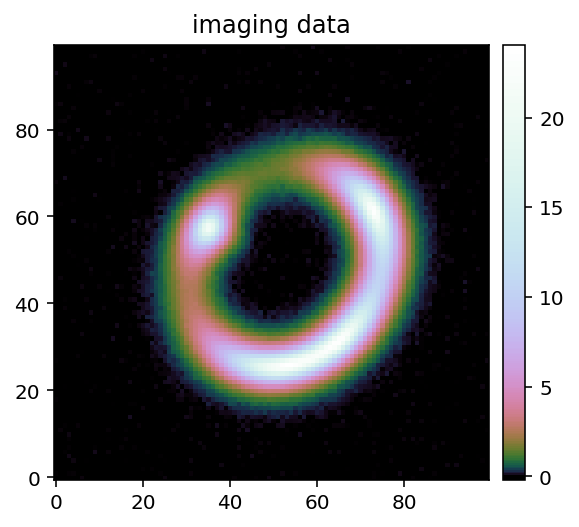

In [3]:
imageModel, data_class, psf_class, lens_model_class, kwargs_truth = generate_simple_mock_lens(100, 0.08)

plt.title("imaging data")
im = plt.imshow(data_class.data, origin='lower', cmap=log_cmap('cubehelix', 1e-2, 1e0))
nice_colorbar(im)
plt.show()

## Settings that will remain fixed

In [4]:
source_model_class_sparsefit = LightModel(['SLIT_STARLETS'])
kwargs_source_sparsefit  = [{'n_scales': 6}]  # starlet coeffs that are optimized for

kwargs_sparse_solver_fixed = {
    'source_interpolation': 'bilinear',
    'sparsity_prior_norm': 1,
    'min_threshold': 3,
    'num_iter_source': 20,
    'num_iter_weights': 2,
    'verbose': False,
    'show_steps': False,
    'thread_count': 8,
}

radius_mask = 3.4
ra_grid, dec_grid = imageModel.ImageNumerics.coordinates_evaluate
likelihood_mask_circular = mask_util.mask_sphere(lenstro_util.array2image(ra_grid), 
                                                 lenstro_util.array2image(dec_grid), 
                                                 0, 0, radius_mask)
#plt.imshow(data_class.data)
#plt.imshow(likelihood_mask_circular, cmap='gray', alpha=0.6)
#plt.show()

## Define functions that vary one setting at a time

In [77]:
def timing_lensing_op_subgrid_res(subgrid_res_range, n_repeat=50):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_lensing_op_min_source_size(min_source_grid_range, subgrid_res_fix=3, n_repeat=50):
    """vary minimal source plane grid size"""
    timing_list, timing_sigma_list = [], []
    for min_source_iter in min_source_grid_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(subgrid_res_fix)
        kwargs_sparse_solver_iter['minimal_source_plane'] = True
        #kwargs_sparse_solver_iter['fix_minimal_source_plane'] = False
        kwargs_sparse_solver_iter['min_num_pix_source'] = min_source_iter
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return min_source_grid_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_noise_levels_subgrid_res(subgrid_res_range, n_repeat=10):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
        imageSparseFit_iter.sparseSolver.set_source_wavelet_scales(kwargs_source_sparsefit[0]['n_scales'])
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.update_source_noise_levels()
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_spectral_norm_subgrid_res(subgrid_res_range, n_repeat=10, force_no_fix=False):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        if force_no_fix:
            kwargs_sparse_solver_iter['fixed_spectral_norm_source'] = None
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
        imageSparseFit_iter.sparseSolver.set_source_wavelet_scales(kwargs_source_sparsefit[0]['n_scales'])
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            if imageSparseFit_iter.sparseSolver.spectral_norm_source_is_fixed:
                pass
                #print(imageSparseFit_iter.sparseSolver.spectral_norm_source)
            else:
                imageSparseFit_iter.sparseSolver.update_spectral_norm_source()
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_solve_source_subgrid_res(subgrid_res_range, n_scales_fix=6, n_repeat=5):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    kwargs_source_sparsefit_fix  = [{'n_scales': n_scales_fix}]  # starlet coeffs that are optimized for
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(subgrid_res_iter)
        #kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            _ = imageSparseFit_iter.image_sparse_solve(kwargs_truth['kwargs_lens'], kwargs_source_sparsefit_fix)
            timing_list_sub.append(time.time() - start)
            #print(imageSparseFit_iter.sparseSolver.best_fit_reduced_chi2)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_solve_source_min_source_size(min_source_grid_range, subgrid_res_fix=3, n_repeat=5):
    """vary minimal allowed source grid size"""
    timing_list, timing_sigma_list = [], []
    for min_source_iter in min_source_grid_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(subgrid_res_fix)
        kwargs_sparse_solver_iter['minimal_source_plane'] = True
        kwargs_sparse_solver_iter['min_num_pix_source'] = min_source_iter
        timing_list_sub = []
        for _ in range(n_repeat):
            # init here so source plane is reinitialised
            imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class,
                                                 lens_model_class=lens_model_class,
                                                 source_model_class=source_model_class_sparsefit,
                                                 likelihood_mask=likelihood_mask_circular, # None
                                                 kwargs_numerics={},
                                                 kwargs_sparse_solver=kwargs_sparse_solver_iter)
            start = time.time()
            _ = imageSparseFit_iter.image_sparse_solve(kwargs_truth['kwargs_lens'], kwargs_source_sparsefit)
            timing_list_sub.append(time.time() - start)
            #print(imageSparseFit_iter.sparseSolver.best_fit_reduced_chi2)
            #imageSparseFit_iter.sparseSolver.plot_results(log_scale=True);plt.show()
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return min_source_grid_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_lensing_op_num_pix(num_pix_range, base_num_pix=100, base_delta_pix=0.08, fix_subgrid_res=2, n_repeat=50):
    """vary number of image pixels"""
    timing_list, timing_sigma_list = [], []
    for num_pix_var in num_pix_range:
        delta_pix_var = num_pix_var / base_num_pix * base_delta_pix  # to keep the same apparent size of the mock lens
        _, data_class_var, _, _, _ = generate_simple_mock_lens(num_pix=num_pix_var, delta_pix=delta_pix_var)
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(fix_subgrid_res)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class_var, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return num_pix_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_solve_source_num_pix(num_pix_range, base_num_pix=100, base_delta_pix=0.08, fix_subgrid_res=2, n_repeat=50):
    """vary number of image pixels"""
    timing_list, timing_sigma_list = [], []
    for num_pix_var in num_pix_range:
        delta_pix_var = num_pix_var / base_num_pix * base_delta_pix  # to keep the same apparent size of the mock lens
        _, data_class_var, _, _, _ = generate_simple_mock_lens(num_pix=num_pix_var, delta_pix=delta_pix_var)
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['supersampling_factor_source'] = int(fix_subgrid_res)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class_var, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            _ = imageSparseFit_iter.image_sparse_solve(kwargs_truth['kwargs_lens'], kwargs_source_sparsefit)
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return num_pix_range, np.array(timing_list), np.array(timing_sigma_list)

## Run the benchmarks 

In [6]:
benchmarks = {}

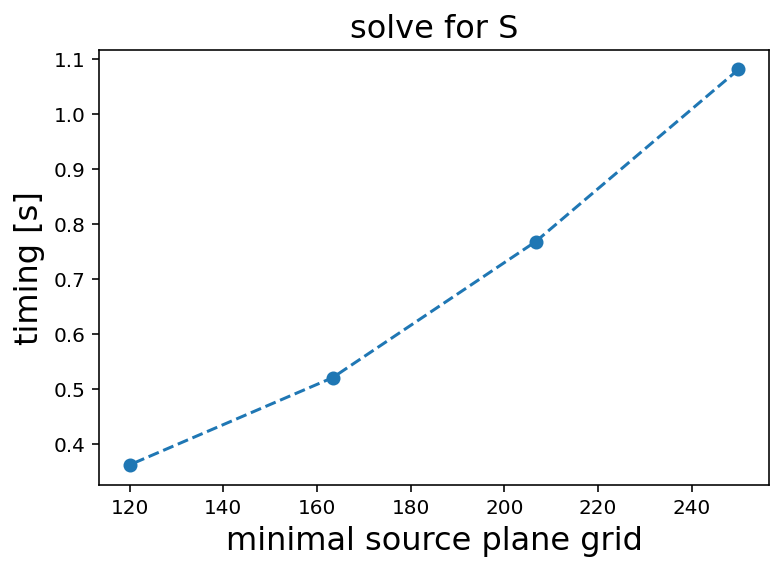

In [68]:
# Time to reconstruct the source for varying minimal source size
x, y, y_err = timing_solve_source_min_source_size(np.linspace(250, 120, 4), n_repeat=1)
benchmarks['timing_solve_source_min_source_size'] = (x, y, y_err)

fig, ax = plt.subplots(1, 1)
ax.errorbar(x, y, yerr=y_err, linestyle='--', marker='o')
ax.set_title("solve for S", fontsize=16)
ax.set_xlabel("minimal source plane grid", fontsize=16)
ax.set_ylabel("timing [s]", fontsize=16)
plt.show()

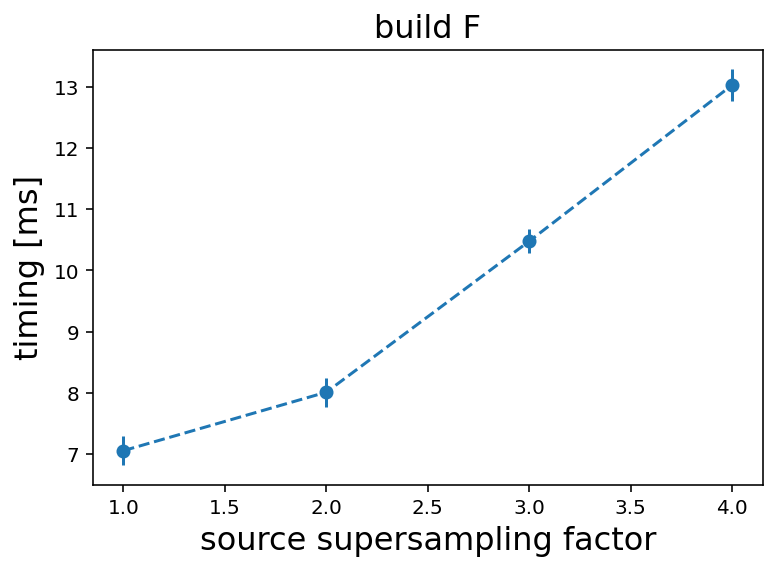

In [8]:
# Time lensing operator construction varying source plane resolution
x, y, y_err = timing_lensing_op_subgrid_res(np.arange(1, 5, dtype=int), n_repeat=10)
benchmarks['timing_lensing_op_subgrid_res'] = (x, y, y_err)
fig, ax = plt.subplots(1, 1)
ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o')
ax.set_title("build F", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
plt.show()

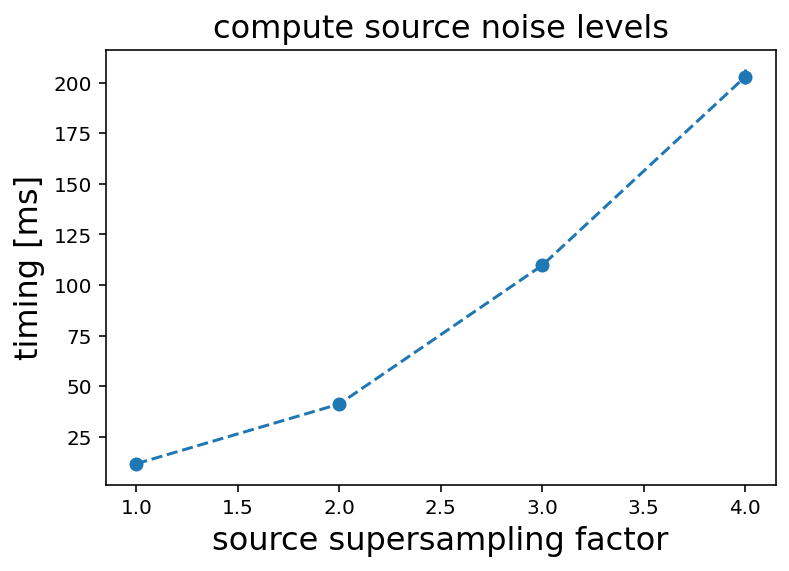

In [9]:
# Noise levels computation
x, y, y_err = timing_noise_levels_subgrid_res(np.arange(1, 5, dtype=int), n_repeat=10)
benchmarks['timing_noise_levels_subgrid_res'] = (x, y, y_err)

fig, ax = plt.subplots(1, 1)
ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o')
ax.set_title("compute source noise levels", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
plt.show()

In [ ]:
# Time lensing operator construction varying number of image pixels
num_pix_range = [100, 200, 500, 1000]
sgr_list, xy_list = [2, 3, 4], []
for sgr in sgr_list:
    x, y, y_err = timing_lensing_op_num_pix(num_pix_range, fix_subgrid_res=sgr, n_repeat=10)
    xy_list.append((x, y, y_err))
benchmarks['timing_lensing_op_num_pix'] = (sgr_list, xy_list)

fig, ax = plt.subplots(1, 1)
for sgr, (x, y, y_err) in zip(sgr_list, xy_list):
    ax.errorbar(x, y*1000, yerr=y_err*1000, linestyle='--', marker='o', label=f"source subgrid res {sgr}")
ax.set_title("build F", fontsize=16)
ax.set_xlabel("number of image side pixels", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
ax.legend(fontsize=12)
plt.show()

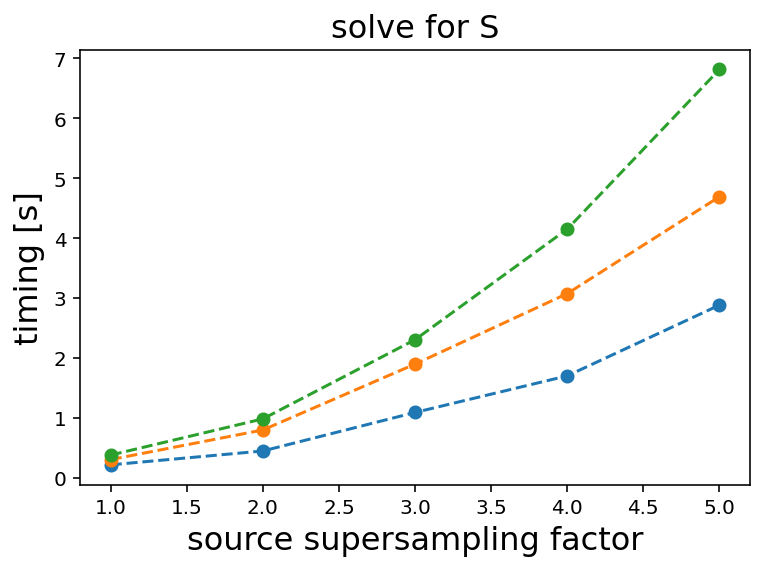

In [79]:
# Time to reconstruct the source for varying resolutions
subgrid_res_list = np.arange(1, 6, dtype=int)
J_s_list, xy_list = [4, 6, 8], []
for J_s in J_s_list:
    x, y, y_err = timing_solve_source_subgrid_res(subgrid_res_list, n_scales_fix=J_s, n_repeat=1)
    xy_list.append((x, y, y_err))
benchmarks['timing_solve_source_subgrid_res'] = (x, y, y_err)
benchmarks['timing_solve_source_subgrid_res'] = (J_s_list, xy_list)

fig, ax = plt.subplots(1, 1)
for J_s, (x, y, y_err) in zip(J_s_list, xy_list):
    ax.errorbar(x, y, yerr=y_err, linestyle='--', marker='o', label=f"{J_s}")
ax.set_title("solve for S", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [s]", fontsize=16)
ax.legend()
plt.show()

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Optimization/solver_base.py:449: RuntimeWarning: overflow encountered in exp
  weights_S  = 1. / ( 1 + np.exp(10 * (alpha_S - lambda_S)) )  # fixed Eq. (C.1)
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Optimization/solver_base.py:449: RuntimeWarning: overflow encountered in exp
  weights_S  = 1. / ( 1 + np.exp(10 * (alpha_S - lambda_S)) )  # fixed Eq. (C.1)
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Optimization/solver_base.py:449: RuntimeWarning: overflow encountered in exp
  weights_S  = 1. / ( 1 + np.exp(10 * (alpha_S - lambda_S)) )  # fixed Eq. (C.1)
/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/slitronomy/Optimization/solver_base.py:449: RuntimeWarning: overflow encountered in exp
  weights_S  = 1. / ( 1 + np.exp(10 * (alpha_S - lambda_S)) )  # fixed Eq. (C.1)
/Use

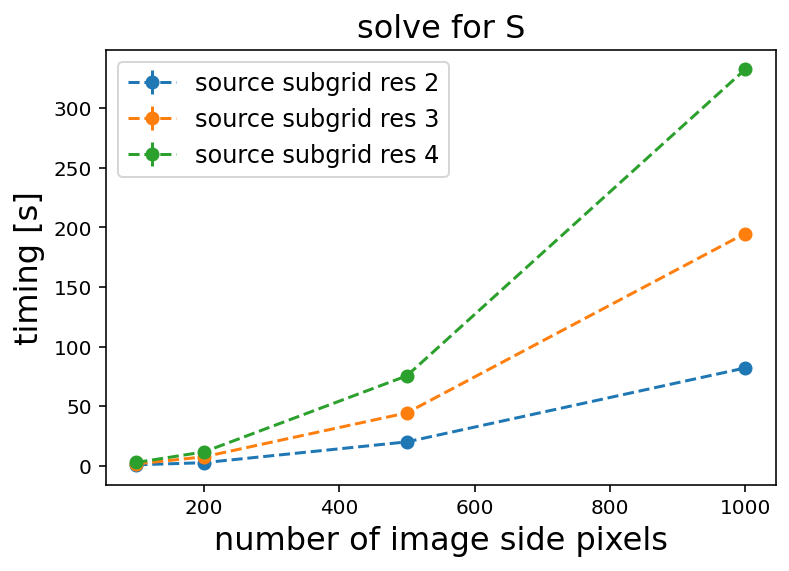

In [13]:
# Time to reconstruct the source for varying number of image pixels
num_pix_range = [100, 200, 500, 1000]
sgr_list, xy_list = [2, 3, 4], []
for sgr in sgr_list:
    x, y, y_err = timing_solve_source_num_pix(num_pix_range, fix_subgrid_res=sgr, n_repeat=1)
    xy_list.append((x, y, y_err))
benchmarks['timing_solve_source_num_pix'] = (sgr_list, xy_list)

fig, ax = plt.subplots(1, 1)
for sgr, (x, y, y_err) in zip(sgr_list, xy_list):
    ax.errorbar(x, y, yerr=y_err, linestyle='--', marker='o', label=f"source subgrid res {sgr}")
ax.set_title("solve for S", fontsize=16)
ax.set_xlabel("number of image side pixels", fontsize=16)
ax.set_ylabel("timing [s]", fontsize=16)
ax.legend(fontsize=12)
plt.show()

## Gather results in a single plot

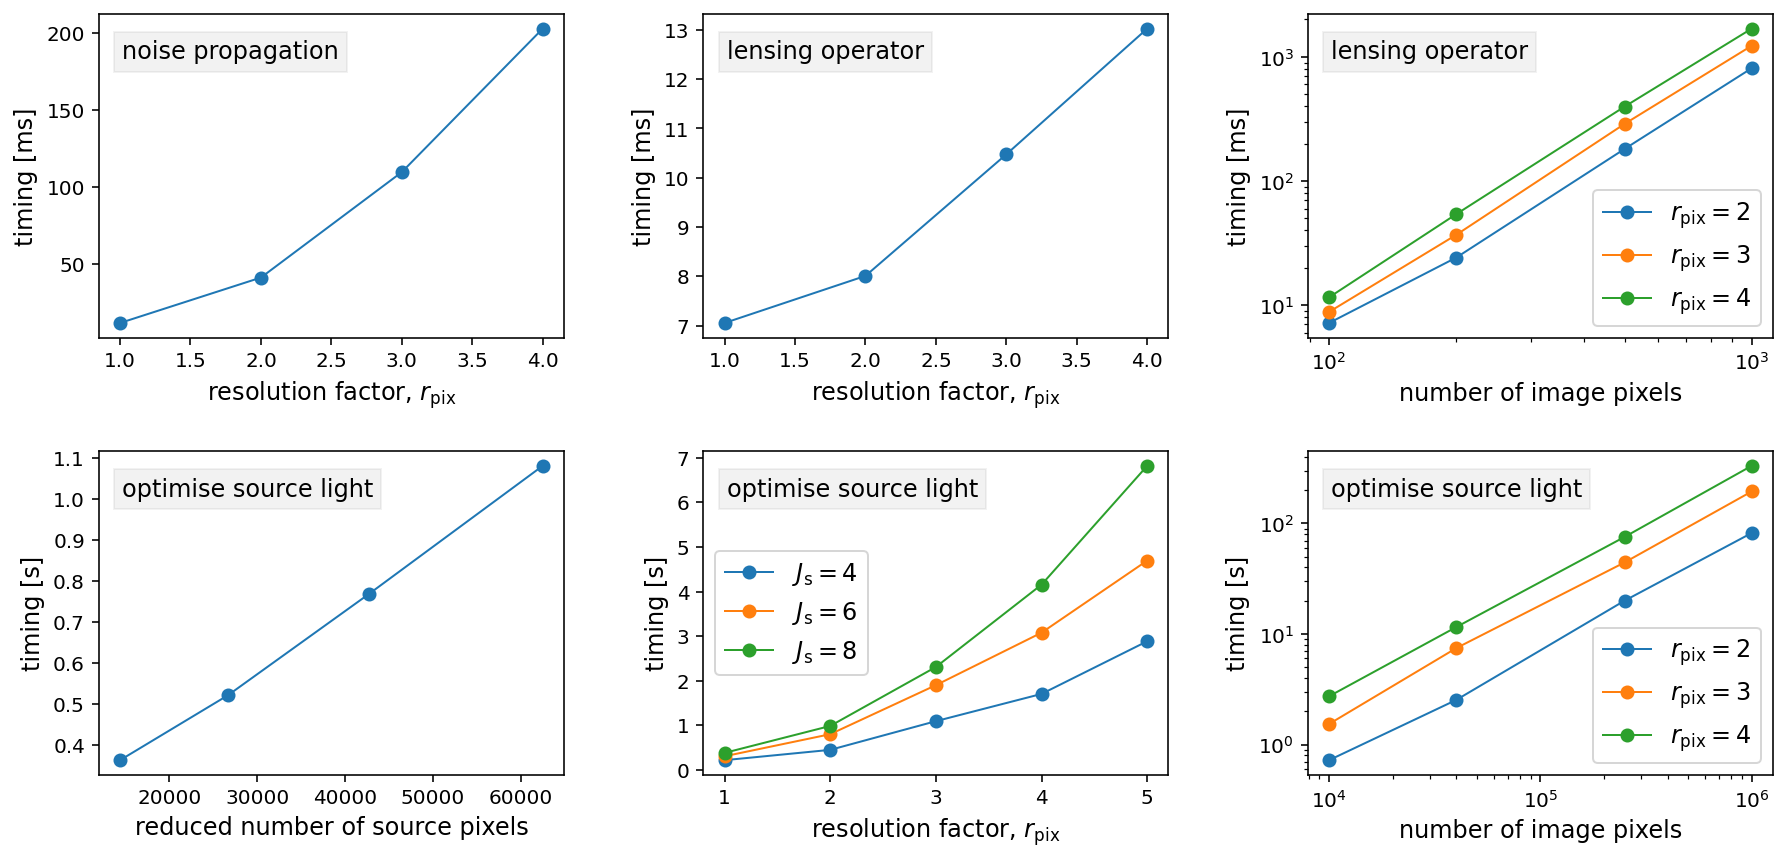

In [87]:
title_fontsize = 12
label_fontsize = 12 
legend_fontsize = 12
linestyle, linewidth = '-', 1
show_errorbar_realizations = False

fig_all, axes_all = plt.subplots(2, 3, figsize=(15, 7))

# Noise levels computation
ax = axes_all[0, 0]
x, y, y_err = benchmarks['timing_noise_levels_subgrid_res']
if show_errorbar_realizations:
    ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle=linestyle, linewidth=linewidth, elinewidth=2, marker='o')
else:
    ax.plot(x, y * 1000, linestyle=linestyle, linewidth=linewidth, marker='o')
ax.text(0.05, 0.92, "noise propagation", fontsize=title_fontsize, transform=ax.transAxes, 
        va='top', ha='left', bbox={'color': 'black', 'alpha': 0.05})
ax.set_xlabel(r"resolution factor, $r_{\rm pix}$", fontsize=label_fontsize)
ax.set_ylabel("timing [ms]", fontsize=label_fontsize)

# Time lensing operator construction varying source plane resolution
ax = axes_all[0, 1]
x, y, y_err = benchmarks['timing_lensing_op_subgrid_res']
if show_errorbar_realizations:
    ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle=linestyle, linewidth=linewidth, elinewidth=2, marker='o')
else:
    ax.plot(x, y * 1000, linestyle=linestyle, linewidth=linewidth, marker='o')
ax.text(0.05, 0.92, "lensing operator", fontsize=title_fontsize, transform=ax.transAxes, 
        va='top', ha='left', bbox={'color': 'black', 'alpha': 0.05})
ax.set_xlabel(r"resolution factor, $r_{\rm pix}$", fontsize=label_fontsize)
ax.set_ylabel("timing [ms]", fontsize=label_fontsize)

# Time lensing operator construction varying number of image pixels
ax = axes_all[0, 2]
sgr_list, xy_list = benchmarks['timing_lensing_op_num_pix']
for sgr, (x, y, y_err) in zip(sgr_list, xy_list):
    x2 = np.array(x)**2
    if show_errorbar_realizations:
        ax.errorbar(x, y*1000, yerr=y_err*1000, linestyle=linestyle, linewidth=linewidth, elinewidth=2, marker='o', 
                    label=r"$r_{\rm pix}="+r"{}".format(sgr)+r"$")
    else:
        ax.plot(x, y*1000, linestyle=linestyle, linewidth=linewidth, marker='o',
                label=r"$r_{\rm pix}="+r"{}".format(sgr)+r"$")
ax.text(0.05, 0.92, "lensing operator", fontsize=title_fontsize, transform=ax.transAxes, 
        va='top', ha='left', bbox={'color': 'black', 'alpha': 0.05})
ax.set_xlabel("number of image pixels", fontsize=label_fontsize)
ax.set_ylabel("timing [ms]", fontsize=label_fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=legend_fontsize, loc='lower right')

# Time to reconstruct the source for varying minimal source size
ax = axes_all[1, 0]
x, y, y_err = benchmarks['timing_solve_source_min_source_size']
x2 = np.array(x)**2
if show_errorbar_realizations:
    ax.errorbar(x2, y, yerr=y_err, linestyle=linestyle, linewidth=linewidth, elinewidth=2, marker='o')
else:
    ax.plot(x2, y, linestyle=linestyle, linewidth=linewidth, marker='o')
ax.text(0.05, 0.92, "optimise source light", fontsize=title_fontsize, transform=ax.transAxes, 
        va='top', ha='left', bbox={'color': 'black', 'alpha': 0.05})
ax.set_xlabel("reduced number of source pixels", fontsize=label_fontsize)
ax.set_ylabel("timing [s]", fontsize=label_fontsize)

# Time to reconstruct the source for varying resolutions
ax = axes_all[1, 1]
J_s_list, xy_list = benchmarks['timing_solve_source_subgrid_res']
for J_s, (x, y, y_err) in zip(J_s_list, xy_list):
    if show_errorbar_realizations:
        ax.errorbar(x, y, yerr=y_err, linestyle=linestyle, linewidth=linewidth, elinewidth=2, marker='o',
                    label=r"$J_{\rm s}="+str(J_s)+r"$")
    else:
        ax.plot(x, y, linestyle=linestyle, linewidth=linewidth, marker='o',
                label=r"$J_{\rm s}="+str(J_s)+r"$")
ax.text(0.05, 0.92, "optimise source light", fontsize=title_fontsize, transform=ax.transAxes, 
        va='top', ha='left', bbox={'color': 'black', 'alpha': 0.05})
ax.set_xlabel(r"resolution factor, $r_{\rm pix}$", fontsize=label_fontsize)
ax.set_ylabel("timing [s]", fontsize=label_fontsize)
ax.legend(fontsize=legend_fontsize, loc='center left')

# Time to reconstruct the source for varying number of image pixels
ax = axes_all[1, 2]
sgr_list, xy_list = benchmarks['timing_solve_source_num_pix']
for sgr, (x, y, y_err) in zip(sgr_list, xy_list):
    x2 = np.array(x)**2
    if show_errorbar_realizations:
        ax.errorbar(x2, y, yerr=y_err, linestyle=linestyle, linewidth=linewidth, elinewidth=2, marker='o', 
                    label=r"$r_{\rm pix}="+r"{}".format(sgr)+r"$")
    else:
        ax.plot(x2, y, linestyle=linestyle, linewidth=linewidth, marker='o', 
                label=r"$r_{\rm pix}="+r"{}".format(sgr)+r"$")
ax.text(0.05, 0.92, "optimise source light", fontsize=title_fontsize, transform=ax.transAxes, 
        va='top', ha='left', bbox={'color': 'black', 'alpha': 0.05})
ax.set_xlabel("number of image pixels", fontsize=label_fontsize)
ax.set_ylabel("timing [s]", fontsize=label_fontsize)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=legend_fontsize, loc='lower right')

fig_all.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)

plt.show()

In [89]:
#fig_all.savefig('figures/benchmarks_SLITronomy.pdf', dpi=100, bbox_inches='tight')